<a href="https://colab.research.google.com/github/mekhanikaladvantage/vneural-pdes/blob/main/DeepRitz_jax_2dslit_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports
!pip install optax
# !pip install --upgrade jax
# !pip install --upgrade jaxlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from jax import jit, grad, vmap, value_and_grad
from jax import random, nn, jacfwd, jacrev
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import math

Exception reporting mode: Context


In [ ]:
key, subkey = random.split(random.PRNGKey(0))

Hyperparameters and Model
=============

In [ ]:
#set hyperparameters
# THIS CELL MUST BE RUN THE RESET THE PARAMETERS OF THE NETWORK

# this creates random parameters for the weights and biases of a given node
def random_layer_params(m:int,n:int,key, scale = 2.0e-1) -> tuple:
    w_key, b_key = random.split(key)

    minval = -6/(jnp.sqrt(m + n))

    maxval = -1*minval

    w = scale * random.uniform(w_key,(n,m),minval = minval,maxval = maxval)
    b = scale * random.uniform(b_key,(n,),minval = minval,maxval = maxval)
    return w,b 

# this should initalize nodes
def init_network_params(sizes:list,key) -> list:
    keys = random.split(key, len(sizes))
    return [random_layer_params(m,n,k) for m,n,k in zip(sizes[:-1],sizes[1:],keys)]


hypers = dict()
hypers["d"] = 2
hypers["m"] = 10
# hypers["m"] = 50
hypers["step size"] = 1e-03
hypers["num epochs"] = 50000
hypers["batch size"] = 256
hypers["boundary size"] = 256
hypers["beta"] = 500.0

# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],1]
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],1] # 1 HL
#experiment architecture:
#3 blocks
layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],1]


params = init_network_params(layer_sizes,subkey)


key, subkey = random.split(key) #this enables us to not fix the initial parameters

optimizer = optax.adam(learning_rate = hypers["step size"])



In [ ]:
from jaxlib.xla_extension import DeviceArray
compiled_celu = jit(nn.celu)
compiled_softplus = jit(nn.softplus)


def relu(x) -> np.float32:
  return jnp.maximum(0,x**3)

def model(params:list,x:DeviceArray) -> np.float32:
    # print("shape of ijnput is {}".format(x.shape))
    '''
    params: list of weight, bias tuples. 
    x: Input vector. Should be shape (2,)
    x[0] is x coord, x[1] is y coord.
    '''

    w,b = params[0]

    output = jnp.dot(w,x) + b
    activations = relu(output)
    residual = activations #will be used for skip connection, needs right dim
    #evenness counter
    layer_number = 1
    i = 0
    # print("activations before lin transform is {}".format(activations))
    
    for w,b in params[1:-1]: #first and last params are for linear transformation
        # output = jnp.add(jnp.dot(w,activations),b)
        output = jnp.dot(w,activations) + b
        activations = relu(output)
        
        if i%2 == 0: #only have skip connection on even blocks
            activations += residual #add skip connection
            residual = activations #update residual
        layer_number += 1
        i += 1
        # # # print("activations after transform is {}".format(activations))
        
    final_w,final_b = params[-1] 
    logits = jnp.dot(final_w,activations) + final_b

    return logits[0]


    #######

batched_model = vmap(model,in_axes=(None,0)) #maps dim(2,128) -> dim(128)

In [ ]:
# model debugging
x = jnp.array([1.0,0.5])
out = model(params,x) # 0.004663214
print(out)

# xs = jnp.ones(shape=(10,))
# ys = jnp.zeros(shape=(10,))
# vector = jnp.stack((xs,ys),axis=1)
# # print(vector)
# outs = batched_model(params,vector)
# print(outs)

# out = jnp.nextafter(1.,jnp.inf)
# print(out)

# print(params)

0.16556036


Batching
===========

In [ ]:
key, subkey = random.split(random.PRNGKey(0))
#  #need static argums batch dim size

nudge = jnp.finfo(np.float32).tiny
print(nudge)

#sampling overhaul: I'm still discretizing stuff. I don't want to discretize anything
# I believe I should sample uniformly for now
def get_batch(batch_size:int,key:DeviceArray) -> DeviceArray:
  return random.uniform(key,shape = (batch_size,hypers["d"]),minval=jnp.nextafter(-1,jnp.inf),maxval=1)


ones = jnp.ones(shape=(hypers["boundary size"],))
slit_size = int(hypers["boundary size"]/2)
zeros = jnp.zeros(shape=(slit_size,))


def get_boundary_batch(bdy_batch_size:int,key:DeviceArray) -> DeviceArray:
  keys = random.split(key,num=5)

  high_end = jnp.nextafter(1,jnp.inf) # to include 1 in sample
  # high_end = 1 + nudge

  top_sample = random.uniform(keys[0],shape=(bdy_batch_size,),minval=-1,maxval=high_end)
  # print(top_sample.shape)
  top = jnp.stack((top_sample,ones),axis=1)

  right_sample = random.uniform(keys[1],shape=(bdy_batch_size,),minval=-1,maxval=high_end)
  right = jnp.stack((ones,right_sample),axis=1)

  bot_sample = random.uniform(keys[2],shape=(bdy_batch_size,),minval=-1,maxval=high_end)
  bot = jnp.stack((bot_sample,-1*ones),axis=1)

  left_sample = random.uniform(keys[3],shape=(bdy_batch_size,),minval=-1,maxval=high_end)
  left = jnp.stack((-1*ones,left_sample),axis=1)

  slit_sample = random.uniform(keys[4],shape=(slit_size,),minval=0,maxval=1)
  slit = jnp.stack((slit_sample,zeros),axis=1)

  boundary = jnp.concatenate((top,right,bot,left,slit),axis=0)
  # boundary = jnp.concatenate((top,right,bot,left),axis=0)

  # all_bdy_xs = jnp.concatenate((top_sample,ones,bot_sample,-1*ones,slit_sample))
  # all_bdy_ys = jnp.concatenate((ones,right_sample,-1*ones,left_sample,zeros))
  return boundary

  # return (all_bdy_xs,all_bdy_ys)

# ones = jnp.ones(shape=(4,))
# zeros = jnp.zeros(shape=(4),)
boundary = get_boundary_batch(hypers["boundary size"],subkey)
# interior = get_batch(4,subkey)
# print(interior)
print(boundary)
# print(f'shape of boundary is {boundary.shape}')

1.1754944e-38
[[ 0.53696775  1.        ]
 [-0.40355515  1.        ]
 [ 0.34293818  1.        ]
 ...
 [ 0.18528831  0.        ]
 [ 0.12491786  0.        ]
 [ 0.7791774   0.        ]]


Loss and Update
======

In [ ]:
'''
loss and update block
'''

from optax._src.base import OptState
from chex._src.pytypes import Device
from jax._src.random import KeyArray

def smooth_abs(x:np.float32, eps = 1e-10)-> np.float32:
    return jnp.sqrt(x**2 + eps)


def flow_loss_fn(params:list,x:DeviceArray) -> np.float32:
  '''
  flow loss calculated on 1 2D sample in order to have scalar output.
  The scalar output is necessary for autograd to work.
  '''
  dudx = grad(model,argnums=1)(params,x) # compute gradient wrt sample
  return 0.5*(jnp.sum(dudx*dudx)) - model(params,x)
  

flow_loss_vector = vmap(flow_loss_fn,in_axes=(None,0)) 

def loss_fn(params:list,key:KeyArray) -> np.float32:
# def loss_fn(params:list,interior_sample,boundary_sample):
  '''
  this function samples data and calculates the loss.
  Please note that this function must be differentiable.
  The loss consists of two parts, an flow loss given by the energy,
  and a boundary loss to enforce boundary conditions. 
  '''
  # generate data
  keys = random.split(key,num=2)
  interior_sample = get_batch(hypers["batch size"],keys[0])
  boundary_sample = get_boundary_batch(hypers["boundary size"],keys[1])
  interior_sample.at[:,1].set(jnp.setdiff1d(interior_sample[:,1],boundary_sample[:,1],size=256,fill_value = 1e-1))


  #calculate flow loss
  flow_output = flow_loss_vector(params,interior_sample)
  flow_loss = jnp.mean(flow_output)


  #calculate boundary loss

  bdy_output = batched_model(params,boundary_sample)
  bdy_loss = hypers["beta"]*jnp.mean((bdy_output*bdy_output))

  return jnp.add(flow_loss,bdy_loss)

def update(params:list,opt_state:OptState,key:KeyArray):

  '''
  This calculates the parameter updates using the ADAM algorithm,
  as implemented in optax.
  '''

  loss,grads = value_and_grad(loss_fn,argnums=0)(params,key)

  updates,opt_state = optimizer.update(grads,opt_state,params)
  params = optax.apply_updates(params,updates)

  return params,opt_state,loss

#jit update for moar speed
compiled_update = jit(update)

In [ ]:
# model debugging
# print(params[0])

x = jnp.array([1.0, 0.75])
out_test = flow_loss_fn(params,x)
# out_test = model(params,x)
print(out_test)

# key = random.PRNGKey(2)
# loss = loss_fn(params,key)
# print(loss)

glue = jnp.ones(shape=(3,1))
gluee = jnp.ones(shape = (3,))
# print(glue)
# print(gluee + gluee)
foo = jnp.reshape(jnp.arange(0,9),(3,3))
bar = jnp.dot(foo,gluee)
# print(bar + gluee)
# print(bar + glue)
baz = jnp.dot(foo,(bar+glue))
# print(baz)

byoom = jnp.dot(foo,(bar+gluee))
# print(byoom)

input = jnp.array([0.5,0])
test = bdy_exact(input)
print(test)

1574.6754
0.0


For more notes on the norm autograd issue, see:
https://github.com/google/jax/issues/6484
https://github.com/google/jax/pull/2447
https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/Custom_derivative_rules_for_Python_code.ipynb
https://github.com/google/jax/issues/1052#issuecomment-514083352
https://github.com/google/jax/issues/3058

In [ ]:
key,bd_key = random.split(random.PRNGKey(41),num=2)

In [ ]:

keys = random.split(bd_key,num=2)
bb = get_boundary_batch(hypers["boundary size"],keys[0])
ib = get_batch(hypers["batch size"],keys[1])
ib.at[:,1].set(jnp.setdiff1d(ib[:,1],bb[:,1],size=256,fill_value = 1e-1))
# print(0.0 in ib[:,1])
print(any([jnp.isclose(x,0.0) for x in ib[:,1]]))
# sample = np.concatenate((bb,ib),axis=0)

# plt.scatter(sample[:,0],sample[:,1])

# indicator_output = [indicator(x,sample) for x in sample]
# print(sample)

num_of_samples = 150
x_range = jnp.linspace(-1,1,num=num_of_samples) #inclusive on inputs and outputs
[Xs,Ys] = jnp.meshgrid(x_range,x_range)



False


Training Block
=========
Next two cells are for resetting the random key and parameters. This is for reproducibility.

Afterwards is the training block.

In [ ]:
#reset key
key, train_key = random.split(random.PRNGKey(20))
params = init_network_params(layer_sizes,train_key)

---------------
Epoch 0 in 0.00 additional seconds
Flow loss is 0.0019450729014351964
Boundary loss is 28.964717864990234
Total loss is 29.206533432006836


<Figure size 640x480 with 0 Axes>

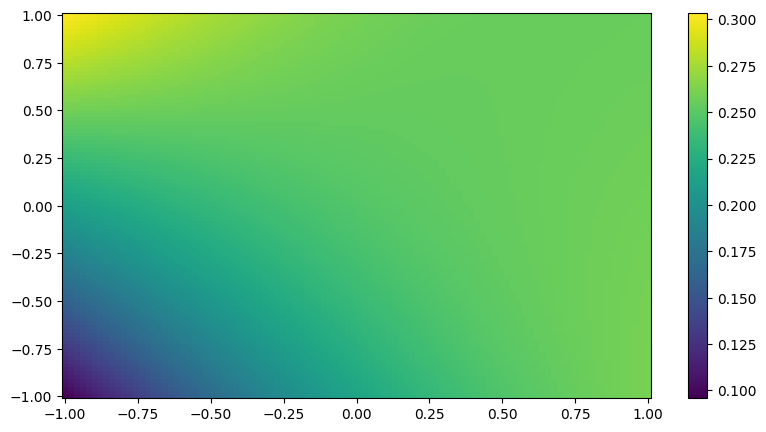

---------------
Epoch 1000 in 4.73 additional seconds
Flow loss is 3.877756171277724e-06
Boundary loss is 0.0010514965979382396
Total loss is 0.00042169506195932627
---------------
Epoch 2000 in 1.96 additional seconds
Flow loss is 7.0469150159624405e-06
Boundary loss is 0.0008921455591917038
Total loss is -0.0008602357702329755
---------------
Epoch 3000 in 1.51 additional seconds
Flow loss is 1.623350544832647e-05
Boundary loss is 0.0011210006196051836
Total loss is -0.0013845507055521011
---------------
Epoch 4000 in 1.46 additional seconds
Flow loss is 4.171009277342819e-05
Boundary loss is 0.0014221119927242398
Total loss is -0.001977495849132538
---------------
Epoch 5000 in 1.49 additional seconds
Flow loss is 0.00028734520310536027
Boundary loss is 0.0020427724812179804
Total loss is -0.004801442846655846


<Figure size 640x480 with 0 Axes>

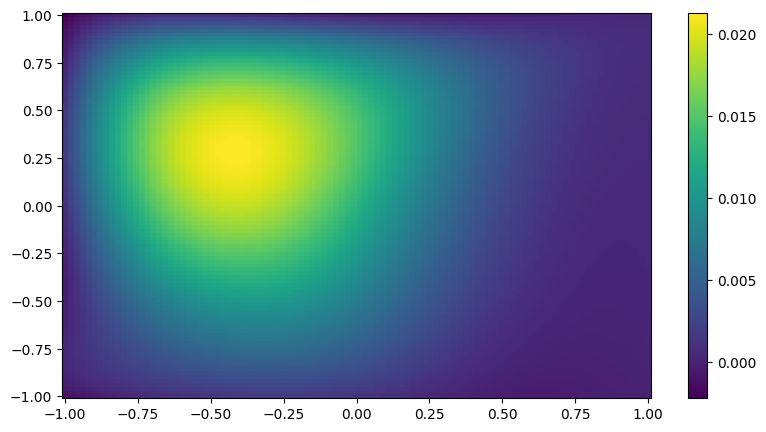

---------------
Epoch 6000 in 4.47 additional seconds
Flow loss is 0.00744423596188426
Boundary loss is 0.00322434538975358
Total loss is -0.017083585262298584
---------------
Epoch 7000 in 1.80 additional seconds
Flow loss is 0.009670013561844826
Boundary loss is 0.003165470203384757
Total loss is -0.021854925900697708
---------------
Epoch 8000 in 1.72 additional seconds
Flow loss is 0.012603689916431904
Boundary loss is 0.0018812281778082252
Total loss is -0.02042737416923046
---------------
Epoch 9000 in 1.48 additional seconds
Flow loss is 0.013929715380072594
Boundary loss is 0.0018361691618338227
Total loss is -0.018628768622875214
---------------
Epoch 10000 in 1.50 additional seconds
Flow loss is 0.01541869156062603
Boundary loss is 0.0032478091306984425
Total loss is -0.024252140894532204


<Figure size 640x480 with 0 Axes>

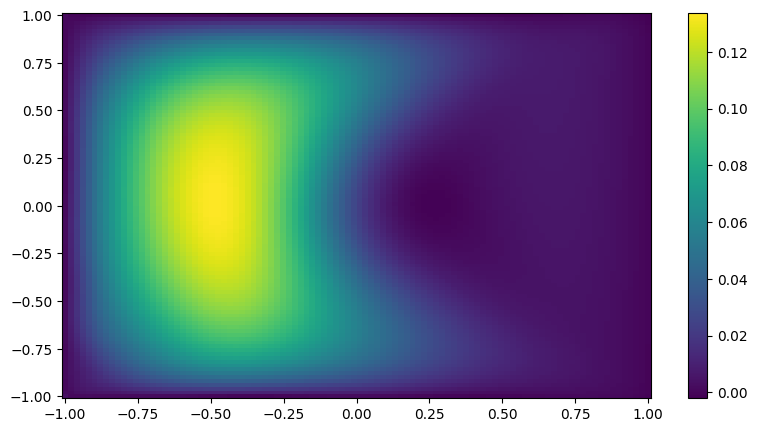

---------------
Epoch 11000 in 4.50 additional seconds
Flow loss is 0.01929551362991333
Boundary loss is 0.003116460982710123
Total loss is -0.02722843363881111
---------------
Epoch 12000 in 1.60 additional seconds
Flow loss is 0.02047831192612648
Boundary loss is 0.0032937496434897184
Total loss is -0.024010969325900078
---------------
Epoch 13000 in 1.95 additional seconds
Flow loss is 0.021184179931879044
Boundary loss is 0.00420626113191247
Total loss is -0.019674628973007202
---------------
Epoch 14000 in 1.49 additional seconds
Flow loss is 0.02020801045000553
Boundary loss is 0.0029815786983817816
Total loss is -0.03016704134643078
---------------
Epoch 15000 in 1.47 additional seconds
Flow loss is 0.02123364806175232
Boundary loss is 0.0044692629016935825
Total loss is -0.030734632164239883


<Figure size 640x480 with 0 Axes>

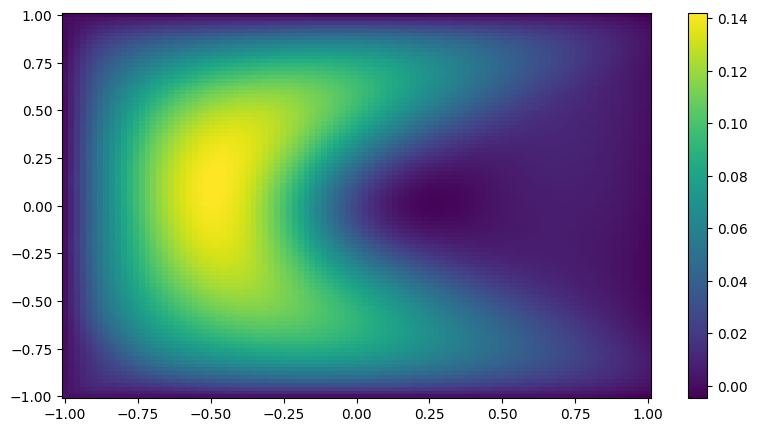

---------------
Epoch 16000 in 4.52 additional seconds
Flow loss is 0.02194240689277649
Boundary loss is 0.0038402066566050053
Total loss is -0.024746369570493698
---------------
Epoch 17000 in 1.47 additional seconds
Flow loss is 0.02373610995709896
Boundary loss is 0.0033553289249539375
Total loss is -0.025749459862709045
---------------
Epoch 18000 in 1.85 additional seconds
Flow loss is 0.023091070353984833
Boundary loss is 0.002587161725386977
Total loss is -0.02577952854335308
---------------
Epoch 19000 in 1.66 additional seconds
Flow loss is 0.023871146142482758
Boundary loss is 0.0027826367877423763
Total loss is -0.028468113392591476
---------------
Epoch 20000 in 1.49 additional seconds
Flow loss is 0.024392006918787956
Boundary loss is 0.0043504610657691956
Total loss is -0.027546502649784088


<Figure size 640x480 with 0 Axes>

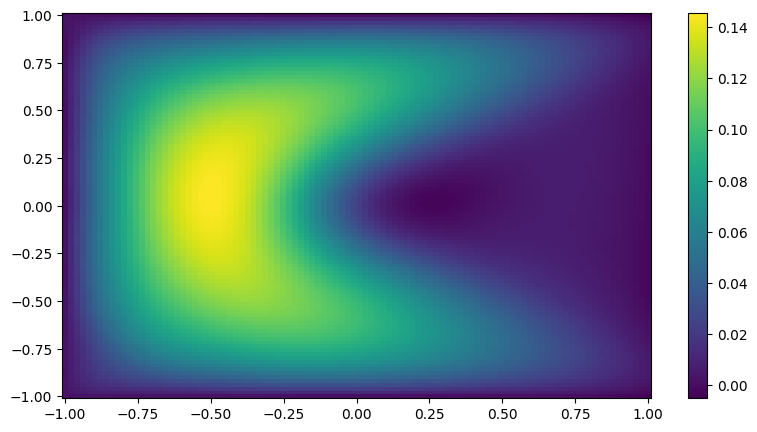

---------------
Epoch 21000 in 4.49 additional seconds
Flow loss is 0.025189533829689026
Boundary loss is 0.0025759972631931305
Total loss is -0.031750764697790146
---------------
Epoch 22000 in 1.49 additional seconds
Flow loss is 0.020867951214313507
Boundary loss is 0.0021769010927528143
Total loss is -0.030624138191342354
---------------
Epoch 23000 in 1.54 additional seconds
Flow loss is 0.021928688511252403
Boundary loss is 0.004115167073905468
Total loss is -0.029100004583597183
---------------
Epoch 24000 in 1.91 additional seconds
Flow loss is 0.02395409345626831
Boundary loss is 0.0030674694571644068
Total loss is -0.02660415507853031
---------------
Epoch 25000 in 1.47 additional seconds
Flow loss is 0.024469692260026932
Boundary loss is 0.0032131252810359
Total loss is -0.031880881637334824


<Figure size 640x480 with 0 Axes>

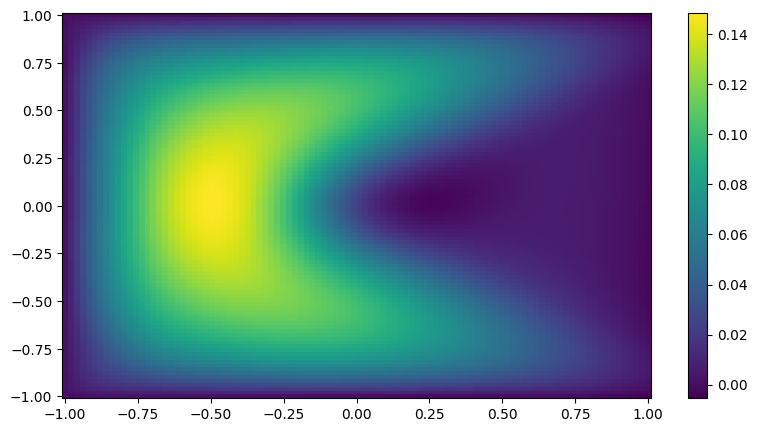

---------------
Epoch 26000 in 4.45 additional seconds
Flow loss is 0.024667685851454735
Boundary loss is 0.002429430605843663
Total loss is -0.0259383711963892
---------------
Epoch 27000 in 1.46 additional seconds
Flow loss is 0.024386504665017128
Boundary loss is 0.0036425215657800436
Total loss is -0.02906578965485096
---------------
Epoch 28000 in 1.49 additional seconds
Flow loss is 0.022905729711055756
Boundary loss is 0.004484440665692091
Total loss is -0.023636993020772934
---------------
Epoch 29000 in 1.86 additional seconds
Flow loss is 0.028019405901432037
Boundary loss is 0.002202663104981184
Total loss is -0.023555349558591843
---------------
Epoch 30000 in 1.66 additional seconds
Flow loss is 0.028142910450696945
Boundary loss is 0.004463535733520985
Total loss is -0.02134569175541401


<Figure size 640x480 with 0 Axes>

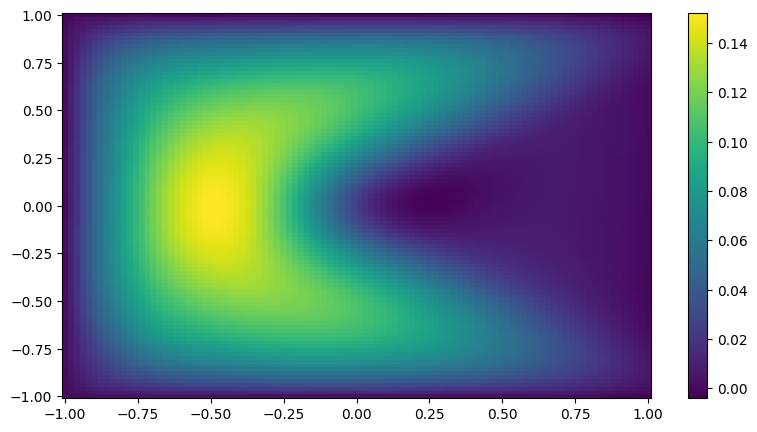

---------------
Epoch 31000 in 5.21 additional seconds
Flow loss is 0.024970365688204765
Boundary loss is 0.004181087017059326
Total loss is -0.027904538437724113
---------------
Epoch 32000 in 1.77 additional seconds
Flow loss is 0.02549264021217823
Boundary loss is 0.004217463079839945
Total loss is -0.029460318386554718
---------------
Epoch 33000 in 1.42 additional seconds
Flow loss is 0.023309864103794098
Boundary loss is 0.003139542182907462
Total loss is -0.032477445900440216
---------------
Epoch 34000 in 1.92 additional seconds
Flow loss is 0.023065125569701195
Boundary loss is 0.0051976037211716175
Total loss is -0.02698039822280407
---------------
Epoch 35000 in 1.58 additional seconds
Flow loss is 0.025218985974788666
Boundary loss is 0.003452364355325699
Total loss is -0.02571563981473446


<Figure size 640x480 with 0 Axes>

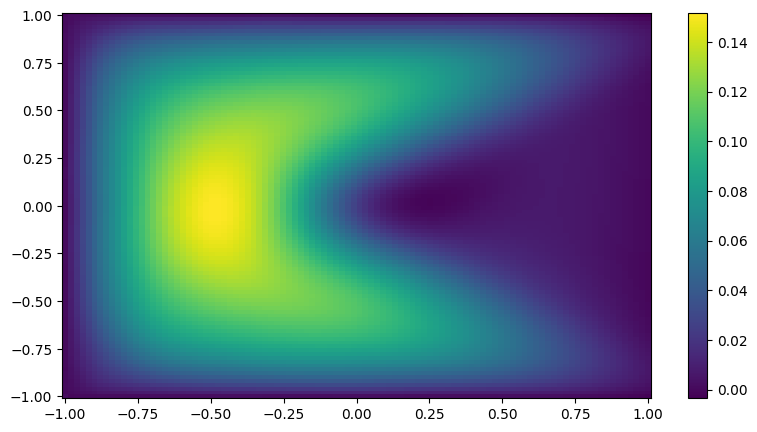

---------------
Epoch 36000 in 4.50 additional seconds
Flow loss is 0.02243298664689064
Boundary loss is 0.0027721254155039787
Total loss is -0.02714984118938446
---------------
Epoch 37000 in 1.45 additional seconds
Flow loss is 0.02903248555958271
Boundary loss is 0.0033756361808627844
Total loss is -0.02027019113302231
---------------
Epoch 38000 in 1.51 additional seconds
Flow loss is 0.024072863161563873
Boundary loss is 0.004518231377005577
Total loss is -0.03160935267806053
---------------
Epoch 39000 in 1.65 additional seconds
Flow loss is 0.02478138543665409
Boundary loss is 0.003093733685091138
Total loss is -0.03418363630771637
---------------
Epoch 40000 in 1.84 additional seconds
Flow loss is 0.025065068155527115
Boundary loss is 0.002875843085348606
Total loss is -0.029349435120821


<Figure size 640x480 with 0 Axes>

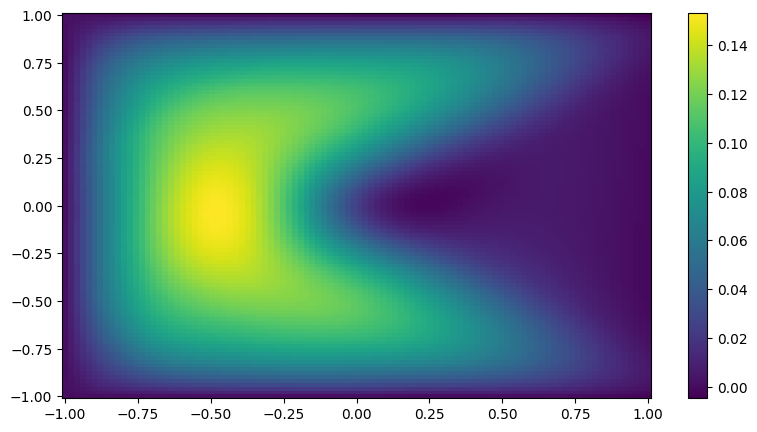

---------------
Epoch 41000 in 4.52 additional seconds
Flow loss is 0.025842931121587753
Boundary loss is 0.0024023631121963263
Total loss is -0.03241797909140587
---------------
Epoch 42000 in 1.53 additional seconds
Flow loss is 0.025822903960943222
Boundary loss is 0.00271295802667737
Total loss is -0.0297258123755455
---------------
Epoch 43000 in 1.46 additional seconds
Flow loss is 0.02683122083544731
Boundary loss is 0.0033930575009435415
Total loss is -0.02934093400835991
---------------
Epoch 44000 in 1.50 additional seconds
Flow loss is 0.023918554186820984
Boundary loss is 0.003815700998529792
Total loss is -0.03397629037499428
---------------
Epoch 45000 in 1.87 additional seconds
Flow loss is 0.026426222175359726
Boundary loss is 0.0034233280457556248
Total loss is -0.026453973725438118


<Figure size 640x480 with 0 Axes>

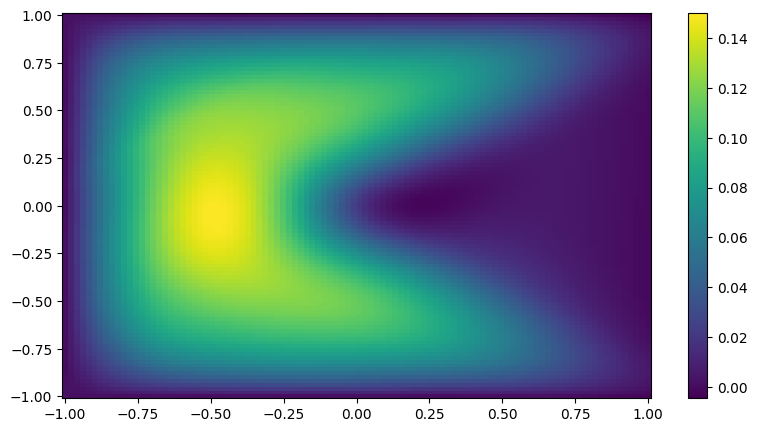

---------------
Epoch 46000 in 4.58 additional seconds
Flow loss is 0.02659558691084385
Boundary loss is 0.0025053273420780897
Total loss is -0.0318942666053772
---------------
Epoch 47000 in 1.48 additional seconds
Flow loss is 0.024036090821027756
Boundary loss is 0.002439399715512991
Total loss is -0.032165464013814926
---------------
Epoch 48000 in 1.51 additional seconds
Flow loss is 0.02387499250471592
Boundary loss is 0.001704363152384758
Total loss is -0.027485771104693413
---------------
Epoch 49000 in 1.47 additional seconds
Flow loss is 0.0229821614921093
Boundary loss is 0.002167356666177511
Total loss is -0.034472573548555374
Epoch 49999 in 1.47 sec
Final loss is  -0.03030841238796711


In [ ]:
#training loop
import time


training_losses = []
flow_losses = []
boundary_losses = []
residuals = []

opt_state = optimizer.init(params)
start_time = time.time()

# checkpoint_params=0
num_of_samples=100
x_range = jnp.linspace(-1,1,num=num_of_samples) #inclusive on ijnputs and outputs
[Xs,Ys] = jnp.meshgrid(x_range,x_range)
temp_output = np.zeros(shape=(num_of_samples,num_of_samples))



for epoch in range(hypers["num epochs"]):
    
    key,train_key = random.split(key)
    
    
    params,opt_state,train_loss = compiled_update(params,opt_state,train_key)


    training_losses.append(train_loss)
    
    if epoch%1000 == 0:
      

      epoch_time = time.time() - start_time

      keys = random.split(train_key,num=2)
      int_out_batch = get_batch(hypers["batch size"],keys[0])
      bdy_out_batch = get_boundary_batch(hypers["boundary size"],keys[1])

      flow_output = flow_loss_vector(params,int_out_batch)
      flow_train_loss = jnp.mean(flow_output)
      flow_losses.append(flow_train_loss)

      bdy_output = batched_model(params,bdy_out_batch)
      bdy_train_loss = hypers['beta']*jnp.mean((bdy_output*bdy_output))
      boundary_losses.append(bdy_train_loss)


      start_time = time.time()
      print("---------------")
      print("Epoch {} in {:0.2f} additional seconds".format(epoch, epoch_time))
      
      print(f'Flow loss is {flow_train_loss}')
      print(f'Boundary loss is {bdy_train_loss}')
      print("Total loss is {}".format(train_loss))
    #end if

    if epoch%5000 == 0:
      plt.clf()
      for i in range(num_of_samples):
        xRow = Xs[i,:]
        yRow = Ys[i,:]
        vector_to_eval = jnp.stack((xRow,yRow),axis=1)
        temp_output[i,:] = batched_model(params,vector_to_eval)
      #end for
      fig, axs = plt.subplots(nrows=1,ncols=1)
      fig.set_size_inches(9.5,5)
      graph_output = axs.pcolormesh(Xs,Ys,temp_output)

      fig.colorbar(graph_output)
      # axs[0].scatter(int_out_batch[:,0],int_out_batch[:,1],c='b')
      # axs[0].scatter(bdy_out_batch[:,0],bdy_out_batch[:,1],c='r')
      plt.show()
    #end if

#end for
    
#once loops ends    
print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time)) #print final epoch info
print("Final loss is  {}".format(train_loss))



Plotting
=======

<Figure size 640x480 with 0 Axes>

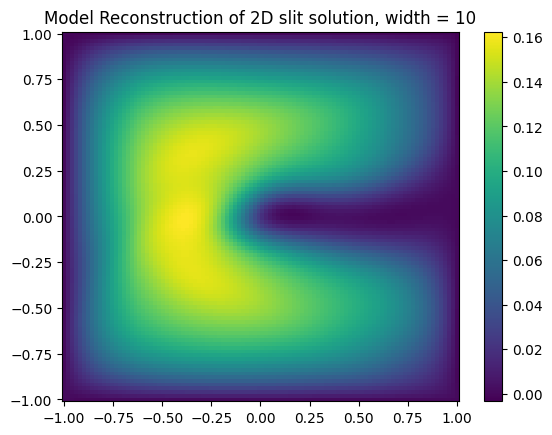

In [ ]:
import array
from jax._src.tree_util import tree_reduce
#plot heatmap
plt.clf()
# params = checkpoint_params
# params = last_cp_params

key,subkey = random.split(key)
num_of_samples = 100

x_range = jnp.linspace(-1,1,num=num_of_samples) #inclusive on inputs and outputs

[Xs,Ys] = jnp.meshgrid(x_range,x_range)
# [Xs,Ys] = jnp.meshgrid(x_range)
output = np.zeros(shape=(num_of_samples,num_of_samples))
graph_losses  = np.zeros(shape=(num_of_samples,num_of_samples))


for i in range(num_of_samples):
  xRow = Xs[i,:]
  yRow = Ys[i,:]
  # mixed_coords =  np.array([xRow,yRow]) #jnp.concatenate((xRow,yRow))
  # print(f'before reshape: {mixed_coords[99:102]}')
  #vector_to_eval = jnp.reshape(mixed_coords,(2,num_of_samples))
  # vector_to_eval = mixed_coords
  vector_to_eval = jnp.stack((xRow,yRow),axis=1)

  output[i,:] = batched_model(params,vector_to_eval)
  # output[i,:] = bdy_exact_vector(vector_to_eval)
  graph_losses[i,:] = flow_loss_vector(params,vector_to_eval)


fig, ax = plt.subplots()
graph_output = ax.pcolormesh(Xs,Ys,output)
fig.colorbar(graph_output)
# print(boundary)
plt.title(f'Model Reconstruction of 2D slit solution, width = {hypers["m"]}')
# plt.savefig(f'2layer_Jax-2dpoisson-slit-solution-width{hypers["m"]}.png')
plt.show()
# print(flows)



# print(output.shape)

Text(0.5, 1.0, 'Boundary Losses')

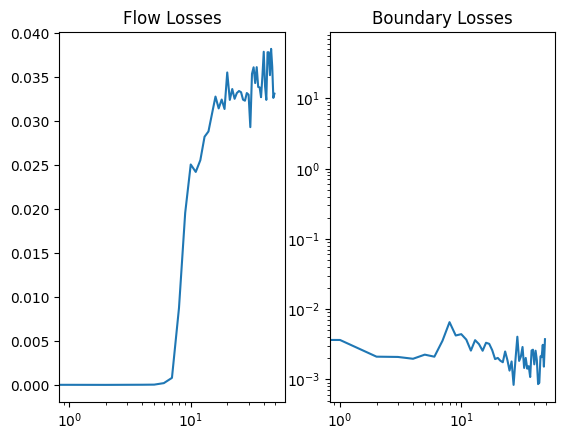

In [ ]:

buffer = [1]*len(training_losses)



fig, axs = plt.subplots(nrows=1,ncols=2)
axs[0].semilogx(flow_losses)
axs[0].set_title("Flow Losses")
axs[1].loglog(boundary_losses)
# axs[1].loglog(residuals)
axs[1].set_title("Boundary Losses")
# axs[1].set_title("Model Losses")
# print(f'minimum model error is {jnp.amin(jnp.array(residuals))}')

# plt.savefig(f'2layer_Flow_and_boundary_losses_width={hypers["m"]}.png')

In [ ]:
# params is a list of (w,b) pairs, want to plot them all on a histogram
weights = []
biases = []

for pair in params:
  # print(f'pair: {pair}')
  weights.append(jnp.ravel(pair[0]))
  # biases.append(pair[1])

